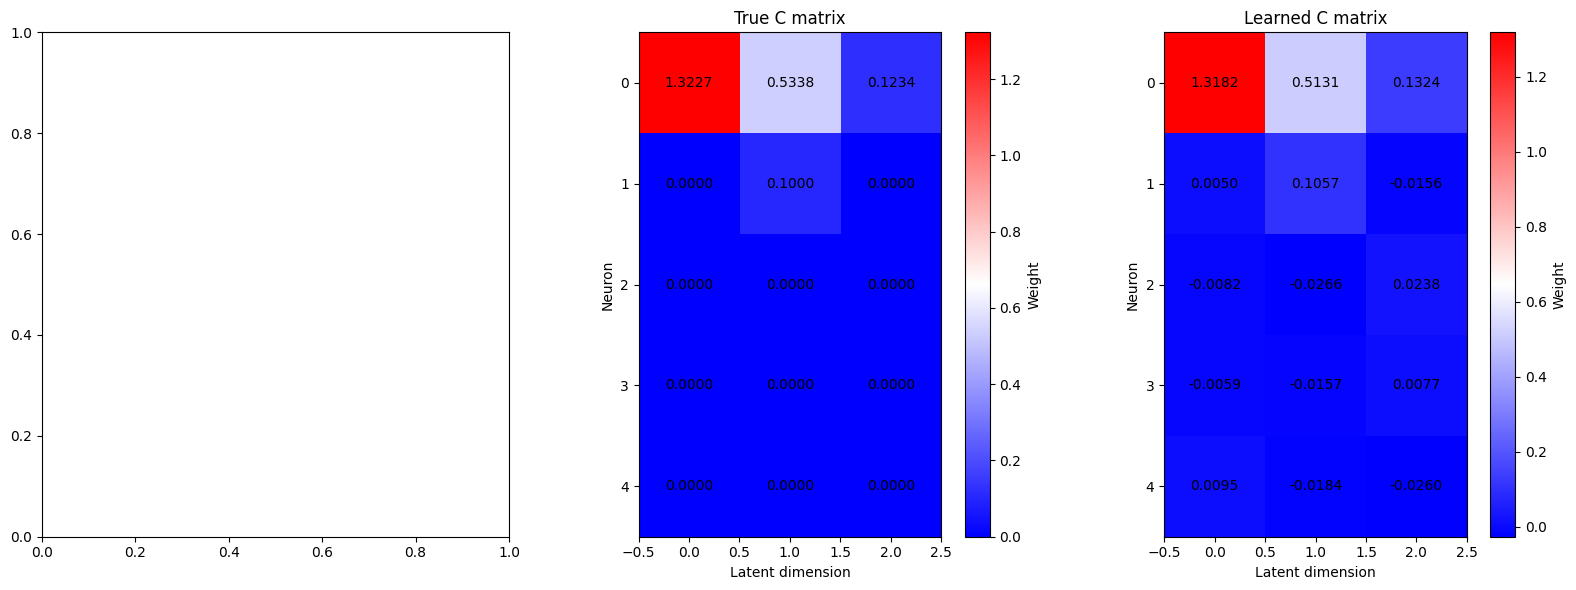

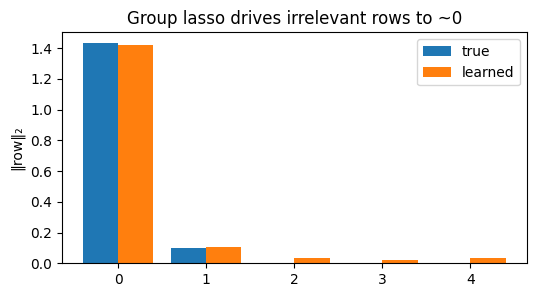

In [93]:
# ================================================================
#  Row‑wise Group Lasso Factor Model (PyTorch, no ARD)
# ================================================================
import torch, matplotlib.pyplot as plt, torch.nn as nn
torch.manual_seed(1)

# ---------- synthetic data --------------------------------------
m, l, n  = 500, 3, 5
true_C   = torch.zeros(n, l)
true_C[0] = torch.randn(l) * 2            # only neuron‑0 matters
true_C[1,1] = 0.1
Z = torch.randn(m, l)
sigma = 0.3
Y = Z @ true_C.T + sigma*torch.randn(m, n)

# ---------- model ------------------------------------------------
class GroupLassoFactor(nn.Module):
    def __init__(self, n, l):
        super().__init__()
        self.C = nn.Parameter(0.01*torch.randn(n, l))

    def loss(self, Z, Y, sigma2, lam):
        recon = Z @ self.C.T
        mse   = ((Y - recon)**2).sum() / (2*sigma2)          # likelihood
        # ----- row‑wise ℓ₂,₁ penalty ----------------------------
        row_norms = self.C.norm(dim=1)                       # ‖row‖₂
        gpen      = lam * row_norms.sum()
        return mse + gpen

model = GroupLassoFactor(n, l)
opt   = torch.optim.Adam(model.parameters(), lr=5e-2)

lam = 1e0                     # try 0.01 … 1.0, pick on validation
for it in range(2000):
    opt.zero_grad()
    loss = model.loss(Z, Y, sigma**2, lam)
    loss.backward()
    opt.step()

# ---------- results ---------------------------------------------
with torch.no_grad():
    learned_C   = model.C.clone()


# Plot learned alpha matrix, true C and learned C
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Plot true C matrix
im2 = ax2.imshow(true_C.detach().numpy(), cmap='bwr')
plt.colorbar(im2, ax=ax2, label='Weight')
ax2.set_title("True C matrix")
ax2.set_xlabel("Latent dimension")
ax2.set_ylabel("Neuron")
for i in range(true_C.shape[0]):
    for j in range(true_C.shape[1]):
        ax2.text(j, i, f'{true_C[i,j]:.4f}',
                ha='center', va='center')

# Plot learned C matrix
im3 = ax3.imshow(learned_C.detach().numpy(), cmap='bwr')
plt.colorbar(im3, ax=ax3, label='Weight')
ax3.set_title("Learned C matrix")
ax3.set_xlabel("Latent dimension")
ax3.set_ylabel("Neuron")
for i in range(learned_C.shape[0]):
    for j in range(learned_C.shape[1]):
        ax3.text(j, i, f'{learned_C[i,j]:.4f}',
                ha='center', va='center')

plt.tight_layout()
plt.show()

# bar‑plot: norms of true vs. learned columns
true_norm  = true_C.norm(dim=1).cpu().numpy()
learn_norm = learned_C.norm(dim=1).cpu().numpy()

plt.figure(figsize=(6,3))
plt.bar(torch.arange(n)-0.2, true_norm, width=0.4, label="true")
plt.bar(torch.arange(n)+0.2, learn_norm, width=0.4, label="learned")
plt.xticks(range(n)); plt.ylabel("‖row‖₂"); plt.legend()
plt.title("Group lasso drives irrelevant rows to ~0")
plt.show()


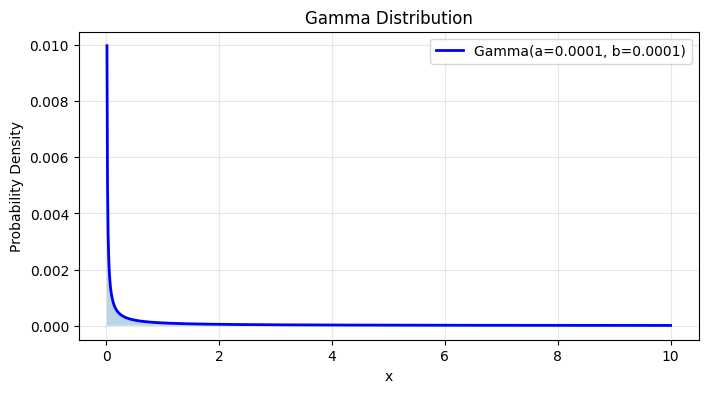

In [63]:
import scipy.stats
import numpy as np

# Define parameters for gamma distribution
a = 1e-4  # shape parameter
b = 1e-4  # rate parameter

# Generate x values
x = np.linspace(0, 10, 1000)

# Calculate gamma distribution
gamma_dist = scipy.stats.gamma.pdf(x, a=a, scale=1/b)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, gamma_dist, 'b-', lw=2, label=f'Gamma(a={a}, b={b})')
plt.fill_between(x, gamma_dist, alpha=0.3)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gamma Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
